# weighting sample by minimize KL via Information Estimator

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.spatial import distance

In [4]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 100)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

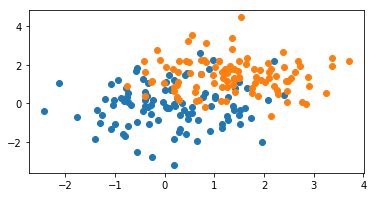

In [5]:
plt.figure(figsize=(6,3))
plt.plot(x[:,0],x[:,1], 'o' )
plt.plot(y[:,0],y[:,1], 'o' )

In [6]:
x.shape

(100, 2)

## make objective vector
データ点$i = 1$に注目した時の目的関数
$\sum_{i=1,i\neq1}\left( \frac{w_i}{(1-w_1)^2}+\frac{w_i}{1-w_i}\log||x_1-x_j|| \right) - \sum_{j=1}\log||x_1 -y_j||$

### internal log component
$\sum_{i=1,i\neq1}\log||x_1-x_j|| $

距離行列を計算する & $\Sigma\log$(各データ点間の距離)をとるので、対角成分は0にする

In [90]:
data_num = x.shape[0]
# make dist matrix
dist_mat_x =distance.cdist(x, x)
# set diagnal component as 0
dist_mat_x[([i for i in range(data_num)], [i for i in range(data_num)])] = 1
log_mat_x = np.log(dist_mat_x)

### weight component
$\sum_{i=1,i\neq1}\frac{w_i}{(1-w_1)^2}+\frac{w_i}{1-w_i}$

この部分を毎回更新する

In [91]:
# initialize weight vector
weight = np.random.uniform(size = data_num)
weight/= np.sum(weight)

In [152]:
# left component
## numeraters matrix
le_numeras_tile = np.tile(weight, (data_num, 1))
# denominators matrix
le_denoms = (1 - weight)**2
le_denoms_tile = np.tile(le_denoms, (data_num, 1)).T
# left_component matrix
mat_le = (le_numeras_tile / le_denoms_tile)

# right component
ri = 1/((1 / weight) - 1)
mat_ri = np.tile(ri, (data_num,1)).T

mat_first = mat_le + mat_ri

In [171]:
mat_first

array([[0.03267257, 0.03504538, 0.02036433, ..., 0.02916203, 0.02540232,
        0.02235234],
       [0.03512811, 0.03751203, 0.02276218, ..., 0.03160111, 0.02782378,
        0.02475951],
       [0.02011984, 0.0224362 , 0.00810442, ..., 0.01669282, 0.01302255,
        0.01004514],
       ...,
       [0.02906093, 0.03141742, 0.01683728, ..., 0.02557451, 0.02184064,
        0.01881163],
       [0.02522084, 0.02756005, 0.01308683, ..., 0.02175999, 0.0180535 ,
        0.01504671],
       [0.02212665, 0.02445198, 0.01006464, ..., 0.01868634, 0.01500184,
        0.01201288]])

重み成分とデータ点間の距離の積

→行列演算の形で

In [157]:
entropy = np.diag(np.dot(mat_first, log_mat_x))

### outer log component
$\sum_{j=1}\log||x_1-y_j|| $

In [172]:
# constant value !
#calculate  only once
dist_mat_xy = distance.cdist(x, y)
log_mat_xy = np.log(dist_mat_xy)
CE = np.sum(log_mat_xy, axis = 1) / data_num

In [173]:
grad = entropy - CE

In [117]:
class CS:
    ''' 
    construct covariate shift sample object
            
    Attributes
    _________
    train: np.ndarray 
        train data assigned to weights(n_data, n_dim)
    test: np.ndarray 
        test data we do not use for training
    '''
        
    def __init__(self, train, test):
        ''' 
            parameters
            _________
            train: np.ndarray 
                train data assigned to weights(n_data, n_dim)
            test: np.ndarray 
                test data we do not use for training
            weight: np.ndarray
                sample weight assigned to train sample
            lr: float
                init learning rate
            lr_list: list
                learning rate history 
            CE: float
                Cross entropy of train sample and test sample
            entropy: float
                self entropy of train sample
        '''
        self.train = train
        self.test = test
        self.weight = np.random.uniform(size = self.train.shape[0])
        self.weight /= self.weight.sum()
        self.lr = 1e-5
        self.lr_list = []
        self.CE = None
        self.entropy = None
    def cal_MKLW(self, rep = 10000):
        """
        Calculate optimal self.weights of self.training data to minimize KL between self.train and self.test

        Parameters
        ________
            rep: int
                maximum repeat number of maximum gradient method
        """

        data_num = self.train.shape[0]

        # self.CE component
            # This is constant value !
            #calculate  only onself.CE!
        dist_mat_xy = distance.cdist(x, y)
        log_mat_xy = np.log(dist_mat_xy)
        self.CE = np.sum(log_mat_xy, axis = 1) / data_num

        # Self-self.entropy component
            # internal log component
        # make dist matrix of self.train
        dist_mat_train =distance.cdist(self.train, self.train)
        # set diagnal component as 0
        dist_mat_train[([i for i in range(data_num)], [i for i in range(data_num)])] = 1
        log_mat_train = np.log(dist_mat_train)


            # self.weight component
        # initialize self.weight vector
        #self.weight = np.random.uniform(size = data_num)
        #self.weight/= np.sum(self.weight)

        for i in range(rep):
                # left component
        ## numeraters matrix
            le_numeras_tile = np.tile(self.weight, (data_num, 1))
                # denominators matrix
            le_denoms = (1 - self.weight)**2
            le_denoms_tile = np.tile(le_denoms, (data_num, 1)).T
                # left_component matrix
            mat_le = (le_numeras_tile / le_denoms_tile)

                # right component
            ri = 1/((1 / self.weight) - 1)
            mat_ri = np.tile(ri, (data_num,1)).T
            # sum of left and right
            mat_first = mat_le + mat_ri
            #self-entropy
            self.entropy = np.diag(np.dot(mat_first, log_mat_train))
            
            while np.sum(self.weight - self.lr * (-self.entropy + self.CE) < 0) !=0 :
                self.lr /= 10 
                
            self.lr_list.append(self.lr)
            self.weight -= self.lr * (-self.entropy + self.CE)
            self.weight /=self.weight.sum()

収束判定どうしよ・・・・

In [131]:
hoge = CS(x,y)
hoge.cal_MKLW(rep=10000)

/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in true_divide
/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide


In [136]:
hoge.lr_list

[1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1.0000000000000002e-06,
 1.0000000000000002e-06,
 1.0000000000000002e-06,
 1.0000000000000002e-06,
 1.0000000000000002e-07,
 1.0000000000000002e-07,
 1.0000000000000002e-08,
 1.0000000000000002e-08,
 1.0000000000000002e-08,
 1.0000000000000002e-08,
 1.0000000000000002e-08,
 1.0000000000000003e-09,
 1.0000000000000003e-09,
 1.0000000000000003e-10,
 1.0000000000000003e-10,
 1.0000000000000003e-10,
 1.00000

/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


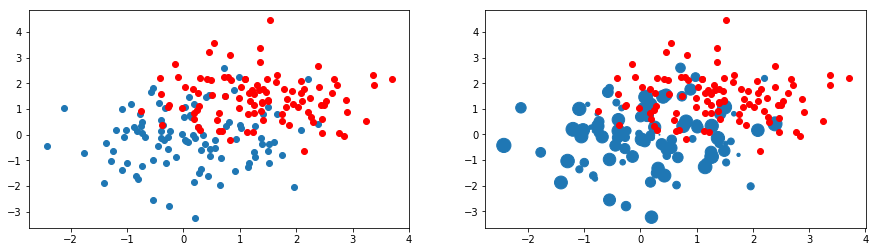

In [76]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1])
plt.plot(y[:,0], y[:,1], 'ro')
plt.subplot(1,2,2)
plt.scatter(x[:,0], x[:,1], s = hoge.weight*10000)
plt.plot(y[:,0], y[:,1], 'ro')